# Classifying Heart Disease in Patients using Multivariate 
#### Research question: Which physiological risk factors are most suitable for accurately classifying heart disease among patients?

## Introduction

(Ada)
- Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
- Clearly state the question you will try to answer with your project
- Identify and describe the dataset that will be used to answer the question 

This dataset includes the many factors considered to diagnose heart disease in a patient. The attributes we will consider include age, sex, and rest BP (resting blood pressure in mm Hg on admission to the hospital). We will use these attributes to train the program to be able to predict the presence of heart disease in new patients. The presence will be on a level of 0 to 4, with 0 being no presence. 

## Preliminary exploratory data analysis

(Nicholas, David)
- Demonstrate that the dataset can be read from the web into R 
- Clean and wrangle your data into a tidy format
- Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
- Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.


In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)
set.seed(100)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
## Loading the Data
heart_data_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_cols <- c("age", "sex", "chest_pain_type", "rest_bp", "cholesterol", "fast_blood_sugar", "rest_ecg", "max_hr", "ex_angina", "st_depr", "slope_peak", "major_vessel_num", "thal", "pres_val")
heart_data <- read_csv(heart_data_url, col_names = heart_cols) |>
    mutate(sex = as.factor(sex),
          chest_pain_type = as.factor(chest_pain_type),
          fast_blood_sugar = as.factor(fast_blood_sugar),
          rest_ecg = as.factor(rest_ecg),
          ex_angina = as.factor(ex_angina),
          major_vessel_num = as.factor(major_vessel_num),
          thal = as.factor(as.integer(thal)),
          pres_val = as.factor(pres_val),
          presence = as.factor(ifelse(pres_val == 0, "no", "yes")))
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): major_vessel_num, thal
dbl (12): age, sex, chest_pain_type, rest_bp, cholesterol, fast_blood_sugar,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in is.factor(x):
“NAs introduced by coercion”


age,sex,chest_pain_type,rest_bp,cholesterol,fast_blood_sugar,rest_ecg,max_hr,ex_angina,st_depr,slope_peak,major_vessel_num,thal,pres_val,presence
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6,0,no
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3,2,yes
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7,1,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7,3,yes
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3,1,yes
38,1,3,138,175,0,0,173,0,0.0,1,?,3,0,no


In [3]:
## Splitting the data into training/testing set
heart_split <- heart_data |>
    select(age, rest_bp, cholesterol, max_hr, st_depr, presence) |>
    initial_split(prop = 0.75, strata = presence)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [4]:
## Summarizing the training data
heart_train_summary <- heart_train |>
    group_by(presence) |>
    summarize(count = n())
heart_train_summary

heart_train_predictors_mean <- heart_train |>
    select(-presence) |>
    colMeans()
heart_train_predictors_mean

presence,count
<fct>,<int>
no,123
yes,104


age     rest_bp cholesterol      max_hr     st_depr 
  54.436123  131.625551  248.775330  149.475771    1.028634

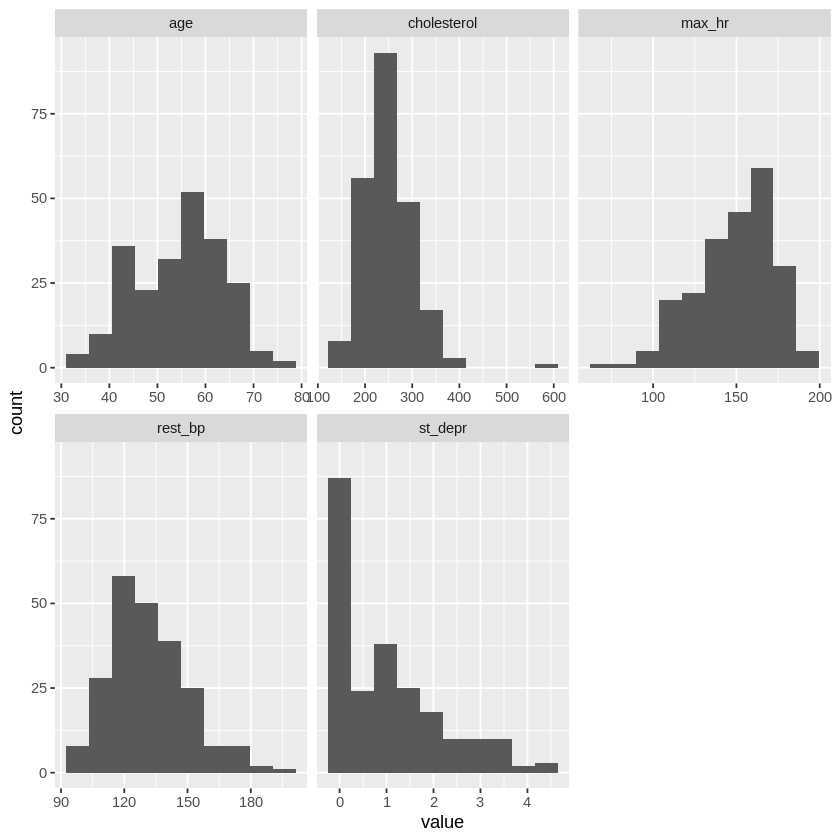

In [5]:
## Visualizing the training data (histogram distributions of each predictor column)
heart_train_long <- heart_train |>
    select(-presence) |>
    pivot_longer(cols = everything(), names_to = "predictor", values_to = "value")

heart_train_predictor_plot <- heart_train_long |>
    ggplot(aes(value)) + 
        geom_histogram(bins = 10) + 
        facet_wrap(~predictor, scales = 'free_x')
heart_train_predictor_plot

In [6]:
## Scaling the data (starting here everything is actually beyond the proposal)
heart_data_recipe <- recipe(presence ~ age + rest_bp + cholesterol + max_hr + st_depr, data = heart_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_data_scaled <- heart_data_recipe |>
    prep() |>
    bake(heart_data)
heart_data_scaled

age,rest_bp,cholesterol,max_hr,st_depr,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.9471596,0.7562740,-0.2644628,0.01716893,1.0855423,no
1.3897030,1.6085589,0.7591593,-1.81889638,0.3965257,yes
1.3897030,-0.6642009,-0.3417173,-0.90086373,1.3439235,yes
⋮,⋮,⋮,⋮,⋮,⋮
0.2833446,-0.09601098,-2.2344526,-1.512885,0.1381444,yes
0.2833446,-0.09601098,-0.2065219,1.066349,-0.8953805,yes
-1.8187363,0.35854099,-1.3846531,1.022633,-0.8953805,no


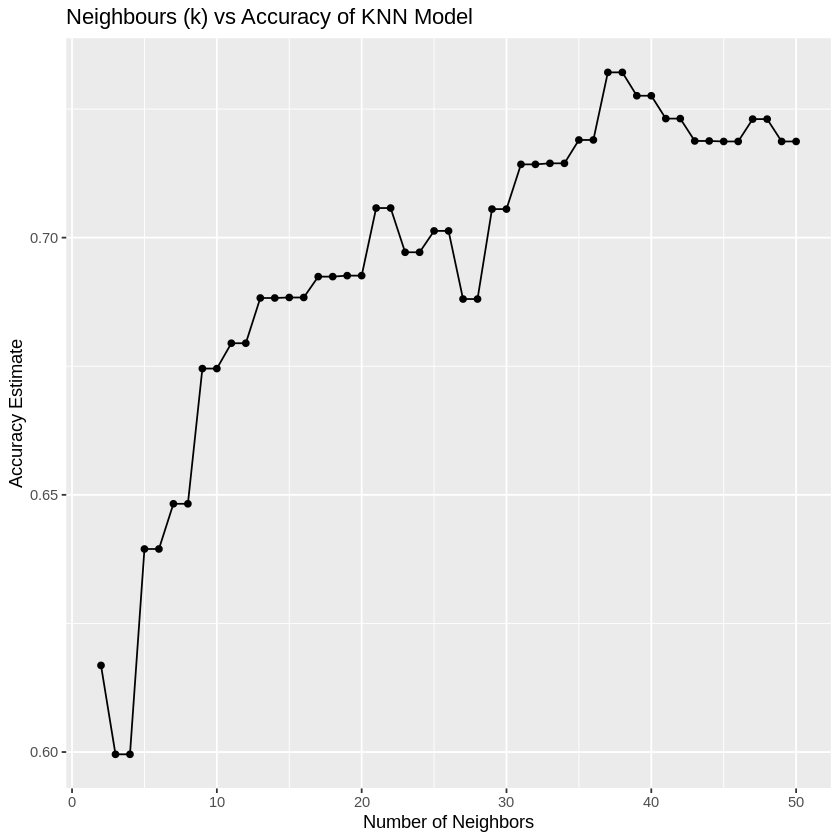

In [7]:
## Finding the optimal k
knn_recipe <- recipe(presence ~ age + rest_bp + cholesterol + max_hr + st_depr, data = heart_train)

heart_train <- knn_recipe |>
    prep() |>
    bake(heart_train)

knn_vfold <- vfold_cv(heart_train, v = 5, strata = presence)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k <- tibble(neighbors = seq(2, 50, 1))

knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = knn_vfold, grid = k) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    ggtitle("Neighbours (k) vs Accuracy of KNN Model") +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate")

cross_val_plot

In [8]:
## Testing the model
knn_spec <- nearest_neighbor(weight = "rectangular", neighbor = 37) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(data = heart_train)

knn_predictions <- predict(knn_fit, heart_test) |>
    bind_cols(heart_test)

knn_metrics <- knn_predictions |>
    metrics(truth = presence, estimate = .pred_class)

knn_conf_mat <- knn_predictions |>
    conf_mat(truth = presence, estimate = .pred_class)

knn_conf_mat

          Truth
Prediction no yes
       no  35  13
       yes  6  22

## Methods

(Ada, Kiara)
For our data analysis, we will use tidymodel’s K-nearest neighbours to classify a new patient as either having heart disease or not. The data set has designated numbers 0 to 4 to represent the various classes of the heart disease diagnosis, with 0 indicating no heart disease and 4 indicating heart disease. A value of 0 suggests the absence of significant heart disease while a value of 1 suggests the presence of heart disease.

We plan on following the main data analysis workflow steps when designing a K-nearest neighbours model to ensure efficiency and clarity. After tidying the data, filtering out the unneeded columns, and scaling and centering the data, we will split the data into a training set and a testing set and use the training set for cross validation. After analyzing the accuracies of various K values using a graph, we will choose the most reliable K value for our K-nearest neighbours model specification, recipe, and workflow.

The raw data contains thirteen columns that have the potential to act as predictors for the diagnosis of heart disease. In our data analysis, we will only use five of these: resting blood pressure in mm Hg (trestbps), serum cholesterol in mg/dl (chol), the number of cigarettes smoked per day (cigs), family history of coronary artery disease (famhist), and whether or not the patient’s fasting blood sugar is greater than 120 mg/dl (fbs).

We will visualize the accuracy of each K value by creating a line plot depicting each K value and their respective accuracy. The plot of accuracy vs. number of neighbours will be used to choose the best K value. Additionally, we will visualize the final results by graphing all of the testing data on a scatter plot with each point coloured based on their predicted classification using our best classification model (one colour corresponds to each number from 0 to 4).

## Expected outcomes and significance

(Sethu)
- What do you expect to find?
 
  1. whether there any significant differences in the occurrence of heart disease between different age groups or genders
  2. Is there a relationship between certain risk factors, such as cholesterol or blood sugar, and the development of heart disease
  3. Predicting the likelihood of developing heart disease based on certain clinical and demographic variables
  4.  whether there are any common symptoms or indicators of heart disease in the dataset

- What impact could such findings have?
 
  1. Improved understanding of risk factors: Identifying significant differences in heart disease occurrence can help healthcare professionals better understand the risk factors associated with heart disease in different populations. This, in turn, can help develop more effective prevention and treatment strategies.
  2.  Targeted interventions: If a particular age group or gender is found to be at higher risk for heart disease, targeted interventions can be developed to address the specific needs of that population. This could include tailored public health campaigns, screening programs, or treatment protocols.
  3.  Resource allocation: Identifying significant differences in heart disease occurrence can also help with resource allocation within healthcare systems. For example, if a particular age group or gender is found to be at higher risk, healthcare providers can allocate resources more efficiently to ensure that these populations receive the necessary care.
      Overall, identifying significant differences in heart disease occurrence between different age groups or genders can have important implications for public health and healthcare delivery.
  4.  Improved prevention strategies: Identifying a significant relationship between specific risk factors and the development of heart disease can help healthcare professionals develop more effective prevention strategies. For example, if high cholesterol is found to be a significant risk factor, healthcare providers may recommend cholesterol-lowering medications or dietary changes to reduce the risk of heart disease.
  5.  Earlier diagnosis: If certain risk factors are found to be associated with the development of heart disease, healthcare providers may recommend earlier screening or diagnostic tests for individuals with these risk factors. This can help detect heart disease at an earlier stage, when it may be more treatable.
  6.  Personalized treatment: If a significant relationship is found between specific risk factors and the development of heart disease, healthcare providers can tailor treatment plans to address the individual needs of each patient. For example, if high blood sugar is found to be a significant risk factor, healthcare providers may recommend tighter blood sugar control for diabetic patients to reduce the risk of heart disease.
  7.  Improved public health: A prediction model can also help inform public health policies and programs by identifying high-risk populations and guiding the development of targeted prevention strategies.
  8.  Early detection: Identifying common symptoms or indicators of heart disease can help healthcare providers detect the disease at an earlier stage. This can lead to earlier interventions and treatments, potentially preventing or delaying the onset of heart disease.

- What future questions could this lead to?